In [1]:
import numpy as np
from numpy import random
import random
import matplotlib.pyplot as plt
from scipy.signal import cwt,ricker
from scipy import stats
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import os
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.optimizers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.layers import Flatten,concatenate,Layer,Dense,LSTM,Activation,MaxPooling2D,Dropout,Conv2D,BatchNormalization,Reshape,UpSampling2D,ZeroPadding2D
import nibabel as nib
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import tensorflow_io as tfio
import radiomics
from radiomics.featureextractor import RadiomicsFeatureExtractor
import SimpleITK as sitk
import pandas as pd


# Training

In [4]:
#TF_ENABLE_ONEDNN_OPTS=0

In [39]:
dict = './covid19/kcv/'

# Function takes a list of folders, extract features from it, change the extractor inside function and the return dictionary
# to run exactly which feature, the key of the return dictionary can be found in mask.ipy and also listed in pyradiomics library
def LoadDataFromImages(foldernames):
    input_array = []
    #output_array=[]
    o1=[]
    o2=[]
    o3=[]
    o4=[]
    o5=[]

    extractor = RadiomicsFeatureExtractor()
    # Disable all classes except firstorder
    extractor.disableAllFeatures()
    extractor.enableFeaturesByName(firstorder=['Skewness'])  # change here to extract
    extractor.enableFeaturesByName(glcm=['Autocorrelation'])
    extractor.enableFeaturesByName(glrlm=['GrayLevelVariance','RunLengthNonUniformity'])
    extractor.enableFeaturesByName(glszm=['SizeZoneNonUniformity'])

    for i in foldernames:
        files  = os.listdir(dict + i)
        for j in files:
            im = sitk.ReadImage(dict + i +'/' + j)
            
            # reshape and fill the input array
            input_array.append(sitk.GetArrayFromImage(im).reshape(512,512,1))
            
            ma_arr = np.ones(im.GetSize()[::-1])  # reverse the order as image is xyz, array is zyx
            ma = sitk.GetImageFromArray(ma_arr)
            ma.CopyInformation(im)  # Copy geometric info
            
            # extract features and fill the output array
            features = extractor.execute(im, ma)
            
            #output_array.append(features['original_ngtdm_Strength'])  # change here to extract
            o1.append(features['original_firstorder_Skewness'])
            o2.append(features['original_glcm_Autocorrelation'])
            o3.append(features['original_glrlm_GrayLevelVariance'])
            o4.append(features['original_glrlm_RunLengthNonUniformity'])
            o5.append(features['original_glszm_SizeZoneNonUniformity'])

            
    return input_array,o1,o2,o3,o4,o5

            

In [40]:
input_array, o1,o2,o3,o4,o5 = LoadDataFromImages(["pos", "neg"])

In [41]:
input_array = np.array(input_array)
o1 = np.array(o1)
o2 = np.array(o2)
o3 = np.array(o3)
o4 = np.array(o4)
o5 = np.array(o5)



In [42]:
np.save("input_arr.npy",input_array)
np.save("o1ar.npy",o1)
np.save("o2ar.npy",o2)
np.save("o3ar.npy",o3)
np.save("o4ar.npy",o4)
np.save("o5ar.npy",o5)

In [98]:
# np.save("input_arr_test.npy",input_array)
# np.save("o1ar_test.npy",o1)
# np.save("o2ar_test.npy",o2)
# np.save("o3ar_test.npy",o3)
# np.save("o4ar_test.npy",o4)
# np.save("o5ar_test.npy",o5)

In [104]:
np.save("input_arr_finet.npy",input_array)
np.save("o1ar_finet.npy",o1)
np.save("o2ar_finet.npy",o2)
np.save("o3ar_finet.npy",o3)
np.save("o4ar_finet.npy",o4)
np.save("o5ar_finet.npy",o5)

In [11]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2022-08-01 17:25:25.974959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-01 17:25:28.126631: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10794 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:0a:00.0, compute capability: 3.7


In [33]:
def MakeModel(modelname):
    input_layer = keras.Input(shape=(512,512,1))
    x = Flatten()(input_layer)
    x = BatchNormalization(axis=1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(1, activation = 'linear', name= modelname)(x)
    model = keras.Model(input_layer, out, name= modelname)
    
    return model

In [34]:
model = MakeModel('covid_RunLengthNonUniformity')

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(
 #learning_rate= 0.0001
), loss="mse", metrics='mae')

In [83]:
model.fit(input_array, o4, 
              epochs=20, 
          batch_size=64,
                shuffle=True
            )

In [40]:
model.save("./covid_RunLengthNonUniformity.h5")

In [275]:
dict = './covid19/testing/'

input_array_t = []
output_array_t = []

input_array_t, output_array_t = LoadDataFromImages([
                                                    'non'

                                                   ])

In [276]:
input_array_t = np.array(input_array_t)
output_array_t = np.array(output_array_t)

10/10 [==============================] - 0s 12ms/step


Text(0.5, 1.0, 'fine_tuned_SizeZoneNonUniformity')

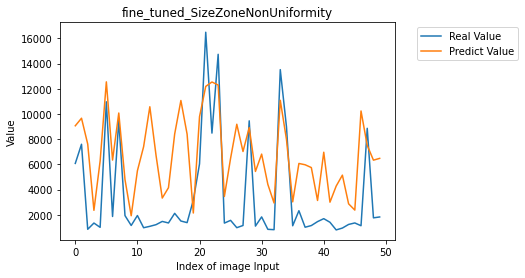

In [279]:
plt.plot(range(50),output_array_t[0:50] ,label='Real Value')
plt.plot(range(50),new_model.predict(input_array_t)[0:50]  ,label='Predict Value')
plt.xlabel("Index of image Input")
plt.ylabel("Value")
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
plt.title('fine_tuned_SizeZoneNonUniformity')

#print(np.mean(test_array7, axis=1))

# Load the Training and Testing Data

In [2]:
# class_names = ['non', 'pos']
# dict = './covid19/testing/'

class_names = ['pos', 'neg']
dict = './covid19/kcv/'

In [3]:

def load_training():
    trainingdata = []
    for i in class_names:
        path = os.path.join(dict, i)
        label_num = class_names.index(i)
        for j in os.listdir(path):
            img = sitk.ReadImage(dict + i +'/' + j)
            trainingdata.append([sitk.GetArrayFromImage(img).reshape(512,512,1),label_num])
            
    return trainingdata
    
            
    

In [4]:
data= load_training()

In [5]:
len(data)

8000

In [6]:
X =[]
Y =[]

for trainingx, label in data:
    X.append(trainingx)
    Y.append(label)

In [7]:
# load input images and output features:
#data = np.load('input_arr.npy')

feature_arr1 = np.load('o1ar.npy')  # original_firstorder_Skewness
feature_arr2 = np.load('o2ar.npy')  # original_glcm_Autocorrelation
feature_arr3 = np.load('o3ar.npy')  # original_glrlm_GrayLevelVariance
feature_arr4 = np.load('o4ar.npy')  # original_glrlm_RunLengthNonUniformity
feature_arr5 = np.load('o5ar.npy')  # original_glszm_SizeZoneNonUniformity



In [8]:
# apply k fold cross validation, k=10
kfold = KFold(10,shuffle=True,random_state=1)

traingroup = []
testgroup=[]

feature1_train= []
feature2_train= []
feature3_train= []
feature4_train= []
feature5_train= []

feature1_test= []
feature2_test= []
feature3_test= []
feature4_test= []
feature5_test= []

output_label_train = []
output_label_test = []




# split data to 10 train and test set
for train, test in kfold.split(X):
    #print('train: %s, test: %s' % (train, test))
    per_train_group = []
    per_test_group=[]
    
    per_feature1_train = []
    per_feature2_train = []
    per_feature3_train = []
    per_feature4_train = []
    per_feature5_train = []
    
    per_feature1_test = []
    per_feature2_test = []
    per_feature3_test = []
    per_feature4_test = []
    per_feature5_test = []
    
    per_label_train =[]
    per_label_test = []
    
    for i in train:
        per_train_group.append(X[i])
        per_label_train.append(Y[i])
        per_feature1_train.append(feature_arr1[i])
        per_feature2_train.append(feature_arr2[i])
        per_feature3_train.append(feature_arr3[i])
        per_feature4_train.append(feature_arr4[i])
        per_feature5_train.append(feature_arr5[i])
    for i in test:
        per_test_group.append(X[i])
        per_label_test.append(Y[i])
        per_feature1_test.append(feature_arr1[i])
        per_feature2_test.append(feature_arr2[i])
        per_feature3_test.append(feature_arr3[i])
        per_feature4_test.append(feature_arr4[i])
        per_feature5_test.append(feature_arr5[i])
        
        
    traingroup.append(per_train_group)
    testgroup.append(per_test_group)
    
    feature1_train.append(per_feature1_train)
    feature2_train.append(per_feature2_train)
    feature3_train.append(per_feature3_train)
    feature4_train.append(per_feature4_train)
    feature5_train.append(per_feature5_train)
    
    feature1_test.append(per_feature1_test)
    feature2_test.append(per_feature2_test)
    feature3_test.append(per_feature3_test)
    feature4_test.append(per_feature4_test)
    feature5_test.append(per_feature5_test)
    
    output_label_train.append(per_label_train)
    output_label_test.append(per_label_test)

        

In [9]:
#convert them into numpy arrays
traingroup = np.array(traingroup)
testgroup= np.array(testgroup)

feature1_train= np.array(feature1_train)
feature2_train= np.array(feature2_train)
feature3_train= np.array(feature3_train)
feature4_train= np.array(feature4_train)
feature5_train= np.array(feature5_train)

feature1_test= np.array(feature1_test)
feature2_test= np.array(feature2_test)
feature3_test= np.array(feature3_test)
feature4_test= np.array(feature4_test)
feature5_test= np.array(feature5_test)

output_label_train = np.array(output_label_train)
output_label_test = np.array(output_label_test)


In [28]:
# clear GPU session
tf.keras.backend.clear_session()

# Regular Neural network with Random initialization

In [80]:
# creating a simple Network
def MakeModel(modelname):
    input_layer = keras.Input(shape=(512,512,1))
    x = Flatten()(input_layer)
    #x = BatchNormalization(axis=1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)

    out = Dense(2, activation = 'softmax', name= modelname)(x)

    model = keras.Model(input_layer, out, name= modelname)
    
    return model

In [86]:
RNNModel = MakeModel('RNNModel')

In [87]:
RNNModel.summary()

Model: "RNNModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 flatten_1 (Flatten)         (None, 262144)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               33554560  
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 RNNModel (Dense)            (None, 2)                 258       
                                                                 
Total params: 33,571,330
Trainable params: 33,571,330
Non-trainable params: 0
_________________________________________________________________


In [88]:
RNNModel.compile(optimizer=tf.keras.optimizers.Adam(
 learning_rate= 0.001
),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy']
                   )

In [89]:
filename='history_rnn.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [90]:
history_rnn = RNNModel.fit(traingroup[9], output_label_train[9], 
                validation_data=([testgroup[9],output_label_test[9]]), 
                batch_size=64,
                epochs=10,
                          callbacks=[history_logger])


Epoch 1/10
113/113 [==============================] - 4s 31ms/step - loss: 1785.6620 - accuracy: 0.8656 - val_loss: 126.5008 - val_accuracy: 0.8825
Epoch 2/10
113/113 [==============================] - 3s 29ms/step - loss: 141.2975 - accuracy: 0.9367 - val_loss: 60.1298 - val_accuracy: 0.9625
Epoch 3/10
113/113 [==============================] - 3s 28ms/step - loss: 435.4829 - accuracy: 0.8946 - val_loss: 543.3359 - val_accuracy: 0.8913
Epoch 4/10
113/113 [==============================] - 3s 30ms/step - loss: 73.3840 - accuracy: 0.9425 - val_loss: 5.8307 - val_accuracy: 0.9775
Epoch 5/10
113/113 [==============================] - 3s 28ms/step - loss: 123.0409 - accuracy: 0.9382 - val_loss: 114.3696 - val_accuracy: 0.9450
Epoch 6/10
113/113 [==============================] - 3s 28ms/step - loss: 76.5389 - accuracy: 0.9303 - val_loss: 26.0958 - val_accuracy: 0.9650
Epoch 7/10
113/113 [==============================] - 3s 28ms/step - loss: 14.7973 - accuracy: 0.9749 - val_loss: 5.5689 - 

# Simple models with raw features

In [96]:
features_train = np.stack((feature1_train,feature2_train,feature3_train,feature4_train, feature5_train),axis=2)
features_test = np.stack((feature1_test,feature2_test,feature3_test,feature4_test, feature5_test),axis=2)

In [97]:
features_train.shape

(10, 7200, 5)

In [168]:


def MakeModel(modelname):
    input_layer = keras.Input(shape=(5))

    
    #x = Flatten()(n_d)
    #x = BatchNormalization(axis=1)(x)
    x = Dense(128, activation='relu')(input_layer)
    x = Dense(128, activation='relu')(x)

    out = Dense(2, activation = 'softmax', name= modelname)(x)

    model = keras.Model(input_layer, out, name= modelname)
    
    return model

In [169]:
rawFeatureModel = MakeModel('rawFeatures')

In [170]:
rawFeatureModel.summary()

Model: "rawFeatures"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_34 (Dense)            (None, 128)               768       
                                                                 
 dense_35 (Dense)            (None, 128)               16512     
                                                                 
 rawFeatures (Dense)         (None, 2)                 258       
                                                                 
Total params: 17,538
Trainable params: 17,538
Non-trainable params: 0
_________________________________________________________________


In [171]:
filename='history_rawfeature.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [172]:
rawFeatureModel.compile(optimizer=tf.keras.optimizers.Adam(
 learning_rate= 0.001
),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
                )

In [173]:
history_rawFeature= rawFeatureModel.fit(features_train[9], output_label_train[9], 
                validation_data=([features_test[9],output_label_test[9]]), 
                batch_size=64,
                epochs=10,
                                       callbacks=[history_logger])

Epoch 1/10
113/113 [==============================] - 1s 4ms/step - loss: 76.3602 - accuracy: 0.8490 - val_loss: 18.5163 - val_accuracy: 0.8975
Epoch 2/10
113/113 [==============================] - 0s 2ms/step - loss: 28.6335 - accuracy: 0.8947 - val_loss: 8.3127 - val_accuracy: 0.8813
Epoch 3/10
113/113 [==============================] - 0s 3ms/step - loss: 44.4648 - accuracy: 0.8856 - val_loss: 226.4645 - val_accuracy: 0.8587
Epoch 4/10
113/113 [==============================] - 0s 3ms/step - loss: 34.4202 - accuracy: 0.8947 - val_loss: 29.7210 - val_accuracy: 0.8788
Epoch 5/10
113/113 [==============================] - 0s 2ms/step - loss: 45.5129 - accuracy: 0.8833 - val_loss: 17.4786 - val_accuracy: 0.8975
Epoch 6/10
113/113 [==============================] - 0s 2ms/step - loss: 27.9457 - accuracy: 0.8929 - val_loss: 12.4996 - val_accuracy: 0.9187
Epoch 7/10
113/113 [==============================] - 0s 2ms/step - loss: 33.8535 - accuracy: 0.8953 - val_loss: 20.2594 - val_accuracy:

# FINs

In [255]:
input_array = np.load('input_arr_finet.npy')
output_array = np.load('o1ar_finet.npy')

In [256]:
base_model =  load_model("radiomics_Skewness.h5")

In [257]:
base_model.summary()

Model: "Skewness"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 flatten_1 (Flatten)         (None, 262144)            0         
                                                                 
 batch_normalization_1 (Batc  (None, 262144)           1048576   
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 64)                16777280  
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                          

In [258]:
# how many layers for saving
newlayers = base_model.layers[6].output
n1 = Dense(64, activation='relu',name = '1')(newlayers)
out = Dense(1, activation='linear',name='2')(n1)
new_model = keras.Model(base_model.input, outputs = out)

In [259]:
new_model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 flatten_1 (Flatten)         (None, 262144)            0         
                                                                 
 batch_normalization_1 (Batc  (None, 262144)           1048576   
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 64)                16777280  
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                          

In [260]:
for i in range(len(base_model.layers)): 
    keras.layers.trainable = True   # True--> fine tine, False-->frozen

In [269]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(
 learning_rate= 0.00001
), loss="mse")

In [270]:
new_model.fit(input_array, output_array, 
              epochs=100, 
          batch_size=64,
                shuffle=True
            )

Epoch 1/100
7/7 [==============================] - 1s 35ms/step - loss: 0.0875
Epoch 2/100
7/7 [==============================] - 0s 31ms/step - loss: 0.1135
Epoch 3/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0765
Epoch 4/100
7/7 [==============================] - 0s 27ms/step - loss: 0.0544
Epoch 5/100
7/7 [==============================] - 0s 27ms/step - loss: 0.0716
Epoch 6/100
7/7 [==============================] - 0s 27ms/step - loss: 0.0537
Epoch 7/100
7/7 [==============================] - 0s 27ms/step - loss: 0.0689
Epoch 8/100
7/7 [==============================] - 0s 27ms/step - loss: 0.0619
Epoch 9/100
7/7 [==============================] - 0s 27ms/step - loss: 0.0545
Epoch 10/100
7/7 [==============================] - 0s 27ms/step - loss: 0.0469
Epoch 11/100
7/7 [==============================] - 0s 27ms/step - loss: 0.0386
Epoch 12/100
7/7 [==============================] - 0s 27ms/step - loss: 0.0482
Epoch 13/100
7/7 [==============================]

In [272]:
new_model.save("./finetune_Skewness.h5")

In [18]:
#Make the model using the Fins

# loading FINs
m1 = load_model('finetune_Skewness.h5')
m2 = load_model('finetune_Autocorrelation.h5')
m3 = load_model('finetune_GrayLevelVariance.h5')
m4 = load_model('finetune_RunLengthNonUniformity.h5')
m5 = load_model('finetune_SizeZoneNonUniformity.h5')


def MakeModel(modelname):
    input_layer = keras.Input(shape=(512,512,1))
    
    l1 = m1(input_layer)
    l2 = m2(input_layer)
    l3 = m3(input_layer)
    l4 = m4(input_layer)
    l5 = m5(input_layer)

    
    n_d = concatenate([l1,l2
                       ,l4,l3,l5
                      ])
    x = Dense(128, activation='relu')(n_d)
    x = Dense(128, activation='relu')(x)

    out = Dense(2, activation = 'softmax', name= modelname)(x)

    model = keras.Model(input_layer, out, name= modelname)
    
    return model

In [19]:
FinModel = MakeModel('Fin')

In [20]:
FinModel.summary()

Model: "Fin"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_15 (Functional)          (None, 1)            17842561    ['input_2[0][0]']                
                                                                                                  
 model_14 (Functional)          (None, 1)            34669313    ['input_2[0][0]']                
                                                                                                  
 model_8 (Functional)           (None, 1)            34714561    ['input_2[0][0]']              

In [21]:
filename='history_fin.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [22]:
FinModel.compile(optimizer=tf.keras.optimizers.Adam(
 learning_rate= 0.001
),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy']
                   )

In [ ]:
history_fin = FinModel.fit(traingroup[4], output_label_train[4], 
                validation_data=([testgroup[4],output_label_test[4]]), 
                batch_size=64,
                epochs=10, callbacks=[history_logger])

In [17]:
# hist_df = pd.DataFrame(history_fin.history) 
# hist_csv_file = 'history_fin.csv'
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)

# Plot Graph

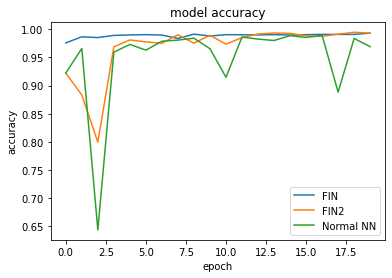

In [73]:


plt.plot(history_fin1.history['val_accuracy'])
plt.plot(history_fin2.history['val_accuracy'])
plt.plot(history_sn.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['FIN','FIN2' ,'Normal NN'], loc='lower right')
plt.show()

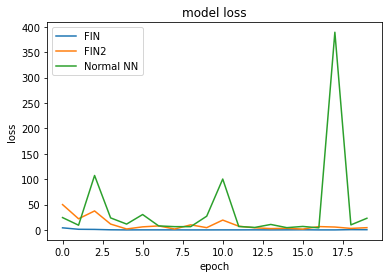

In [74]:
plt.plot(history_fin.history['val_loss'])
plt.plot(history_fin2.history['val_loss'])
plt.plot(history_sn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['FIN','FIN2', 'Normal NN'], loc='upper left')
plt.show()